In [1]:
import os
import copy
import pickle
import warnings
import math
import pandas as pd
import numpy as np
import numpy.ma as ma
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import bootstrap
from matplotlib.patches import Ellipse,Annulus,Arc,PathPatch

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import palettable
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture,EllipticalAnnulus

from astropy.utils.console import ProgressBar
from astropy.table import QTable
plt.rc('text', usetex=True)
rcParams.update({'axes.linewidth': 1.5})
rcParams.update({'xtick.direction': 'in'})
rcParams.update({'ytick.direction': 'in'})
rcParams.update({'xtick.minor.visible': 'True'})
rcParams.update({'ytick.minor.visible': 'True'})
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '8.0'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '4.0'})
rcParams.update({'xtick.minor.width': '1.5'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '8.0'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '4.0'})
rcParams.update({'ytick.minor.width': '1.5'})
rcParams.update({'axes.titlepad': '10.0'})
rcParams.update({'font.size': 35})

In [2]:
data_dir="/Users/xushuo/work/Submit/Simulation/data/"
fig_dir="/Users/xushuo/work/Papers/Simulation/Figure/"

In [3]:
with open(data_dir+"galaxies_tng100_072_stellar_mass_map_15.txt",'rb') as f: 
    map_data=pickle.load(f)

In [4]:
with open(data_dir+"galaxies_tng100_072_ell_aperture_1.txt",'rb') as f: 
    tab=pickle.load(f)

In [5]:
tab[tab['gal_num']==15]

gal_num,proj,catsh_primary,mass_halo,mass_stellar_gal,mass_stellar_ins,mass_stellar_exs,aper_10_ins,aper_10_exs,aper_10_gal,aper_10_ins_force,aper_10_exs_force,aper_30_ins,aper_30_exs,aper_30_gal,aper_30_ins_force,aper_30_exs_force,aper_50_ins,aper_50_exs,aper_50_gal,aper_50_ins_force,aper_50_exs_force,aper_75_ins,aper_75_exs,aper_75_gal,aper_75_ins_force,aper_75_exs_force,aper_100_ins,aper_100_exs,aper_100_gal,aper_100_ins_force,aper_100_exs_force,aper_150_ins,aper_150_exs,aper_150_gal,aper_150_ins_force,aper_150_exs_force,ellipticity,ellipticity_ins,ellipticity_exs,ellipticity_10,ellipticity_ins_10,ellipticity_exs_10,ellipticity_30,ellipticity_ins_30,ellipticity_exs_30,ellipticity_40,ellipticity_ins_40,ellipticity_exs_40,ellipticity_50,ellipticity_ins_50,ellipticity_exs_50,ellipticity_inner_10_20,ellipticity_outer_25_45,r_20_ins,r_20_exs,r_20_gal,r_20_ins_force,r_20_exs_force,r_50_ins,r_50_exs,r_50_gal,r_50_ins_force,r_50_exs_force,r_80_ins,r_80_exs,r_80_gal,r_80_ins_force,r_80_exs_force
int64,str2,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
15,xy,True,100169140625000.0,983033477223.0787,417078710644.55743,565954766578.5203,166535452325.687,227269532623.25565,388076652840.81744,154537105808.392,228668260635.46274,298350681005.471,363040799641.5888,659625306769.5199,291761453872.941,362565493096.50604,345179165379.0122,418621767516.97186,763193258727.1758,339976407355.7528,417500208050.5736,376783695607.39026,461656763506.16705,839942650484.6458,373372279529.2299,460495399945.9614,394103857783.4523,492055304673.3979,889359657124.5879,392263569761.68866,490570008518.74725,413963805216.2606,533277173612.896,952382458584.442,413509784715.94165,531599225163.13794,0.3362609177355931,0.21019107812870458,0.3698043024970528,0.26102891839131176,0.2549667874213845,0.272455332502197,0.27849870384033265,0.24707940290664793,0.30639702282775605,0.3033870084084851,0.255588712164724,0.3281781920194675,0.3378288602081716,0.3007683085933559,0.38358656111053735,0.26468412239576633,0.2877977761522246,4.887330620004732,3.099954936382399,3.8175828370207006,5.336543840943064,3.0357402531897852,13.217418420901632,14.26262792227368,14.137226220353433,14.371654710364645,14.002372305887302,42.96879937662529,56.352464082648595,51.53809003962332,46.34702175880724,56.179735359724006
15,yz,True,100169140625000.0,1008369162687.5638,422220983119.66125,586148179567.9028,176458416748.3327,266142921372.44073,443796171285.15137,181121302133.39566,260389671624.32013,303845887973.5643,396569202435.57886,701685948750.7378,307118284506.801,390498854345.05365,350802122434.4846,449834901878.08496,801735715206.6276,353583317538.55396,443825488544.5411,381131463774.3176,492255968032.25977,874040024623.1035,382921151595.8929,485979381544.4763,399277787175.3512,524392949526.0147,923499599378.738,399748229199.91534,518290685288.1777,420038788842.23315,569972875373.6597,989854818551.2583,419085847770.8229,565445573565.3079,0.12947202572806946,0.2205823963077643,0.08010337480748328,0.2966728783548992,0.43270936813397665,0.08753800116395861,0.07589073143889259,0.05589856149663362,0.1268979653259077,0.10994196160230356,0.07447103390465173,0.12279700004091895,0.1119594932587024,0.09620326391272517,0.14858253009870112,0.15017267200055015,0.09419927969770396,4.4693643168400055,2.337607954868199,3.080705783190045,4.244138766760619,2.4736413527518004,13.069751034047252,11.805656269224095,12.356419044274949,12.52404244832916,12.163363645526085,43.264205493655716,54.05484219992992,48.13025316852918,40.82

In [6]:
cmap1=palettable.cartocolors.sequential.agGrnYl_7.mpl_colormap
cmap2=palettable.colorbrewer.sequential.Blues_4.mpl_colormap
cmap3=palettable.colorbrewer.sequential.Greens_4.mpl_colormap
cmap_list=[cmap1,cmap2,cmap3]
cmap0=palettable.cmocean.sequential.Dense_4.mpl_colormap

In [7]:
# Shape of the image
x_size, y_size = map_data.shape

# Get the (min, max) values of the map
map_max = map_data.max()
map_min = map_data[map_data > 0.0].min()   # none-zero min
# Normalize the data so the minimum non-zero value is `min_value`
min_value = 0.01
norm_factor = map_min / min_value
map_norm = map_data / norm_factor



In [8]:
sum0=np.load(os.path.join(data_dir, 'galaxies_tng100_072_ell_aper15_xy.npy'),allow_pickle=True).item()

In [9]:
sum0['ins']

r_kpc,aper_mass
float64,float64
0.0,0.0
0.5383519429661526,3308281539.893208
0.6460223315593832,4609754079.861141
0.7752267978712597,6410151834.618443
0.9302721574455116,8880554406.556374
1.116326588934614,12234807002.32588
...,...
51.35673858195454,347469331307.2502
61.628086298345444,362487699348.78186


In [10]:
sum1=np.load(os.path.join(data_dir, 'galaxies_tng100_072_15_xy.npy'),allow_pickle=True).item()

In [11]:
pa=float(str(sum1['gal']['other']['pa'][1])[:-4:])

In [12]:
eps=sum1['gal']['other']['ellipticity'][1]

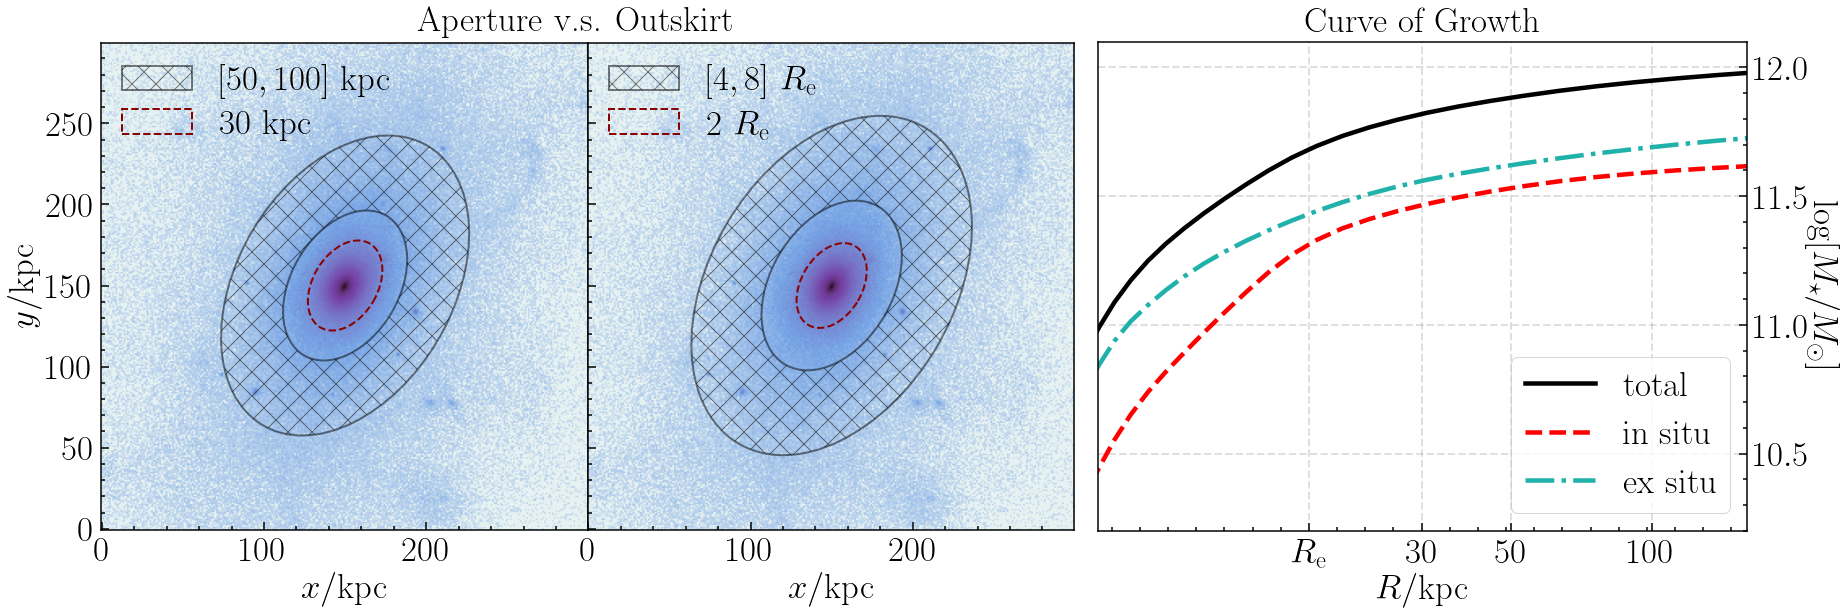

In [13]:
fig=plt.figure(figsize=(29.5, 9))
gs = fig.add_gridspec(1,2, hspace=0, wspace=0.03,width_ratios=(0.6,0.4))
inner_grid=gs[0,0].subgridspec(1,2,hspace=0, wspace=0)
(ax1,ax2)=inner_grid.subplots(sharex='col', sharey='row')
ax3=gs[0,1].subgridspec(1,1,hspace=0, wspace=0).subplots(sharex='col', sharey='row')


ax1.imshow(np.arcsinh(np.sqrt(map_norm*3)), origin='lower',cmap=cmap0)

ell=Ellipse((150,150),60,60*(1-eps),angle=pa,fill=False,ls='--',lw=2,color='darkred',label=r'$30{\rm\ kpc}$')
band=EllipticalAnnulus((150,150),a_in=50,a_out=100,b_in=50*(1-eps),b_out=100*(1-eps),theta=pa*np.pi/180)
band1=band._to_patch(hatch='x',color='black',label=r'$[50,100]${\rm\ kpc}',alpha=0.5,lw=2)
ax1.add_patch(band1)
ax1.add_artist(ell)
ax1.legend(loc=2,labelcolor='Black',frameon=False,labelspacing=0.3,borderaxespad=0.2)
ax1.set_xlabel(r'$x/{\rm {kpc}}$')
ax1.set_ylabel(r'$y/{\rm {kpc}}$')

ax2.imshow(np.arcsinh(np.sqrt(map_norm*3)),origin='lower',cmap=cmap0)
reff=tab['r_50_gal'][tab['gal_num']==15][0]
ell1=Ellipse((150,150),2*2*reff,2*2*reff*(1-eps),angle=pa,fill=False,ls='--',lw=2,color='darkred',label=r'$2\ R_{\rm e}$')
band=EllipticalAnnulus((150,150),a_in=4*reff,a_out=8*reff,b_in=4*reff*(1-eps),b_out=8*reff*(1-eps),theta=pa*np.pi/180)
band2=band._to_patch(hatch='x',color='black',label=r'$[4,8]\ R_{\rm e}$',alpha=0.5,lw=2)
ax2.add_patch(band2)
ax2.add_artist(ell1)

ax2.legend(loc=2,labelcolor='Black',frameon=False,labelspacing=0.3,borderaxespad=0.2)
ax2.set_xlabel(r'$x/{\rm kpc}$')

map_list=['gal','ins_force','exs_force']
label_list=[r'\rm total',r'\rm in situ',r'\rm ex situ']
color_list=['black','red','lightseagreen']
ls_list=['-','--','-.']
for ii in range(3):
    cog=sum0[map_list[ii]]
    xdata=cog['r_kpc'][1::]**0.25
    ydata=np.log10(cog['aper_mass'][1::])
    ax3.plot(xdata,ydata,color=color_list[ii],ls=ls_list[ii],label=label_list[ii],lw=4.5)
ax3.legend()
ax3.set_ylabel(r'$\log[M_{\star}/M_\odot]$',fontsize=35,rotation=-90,labelpad=28)
ax3.set_xlabel(r'$R/{\rm kpc}$',fontsize=35)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_title(r'\rm Curve of Growth',fontsize=35)
xtick=np.asarray((reff,30,50,100))**0.25
xtick0=[r'$R_{\rm e}$',r'$30$',r'$50$',r'$100$']
ax3.set_xticks(list(xtick),xtick0)
ax3.set_xlim(2**0.25,150**0.25)
ax3.set_ylim(10.2,12.1)
ax3.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)
ax1.text(0.65, 1.025, r'\rm Aperture v.s. Outskirt', transform=ax1.transAxes, size=35)
plt.savefig(fig_dir+"Fig1.png",dpi=150)

In [63]:
np.max(map_norm)

1895.5094976770904

In [99]:
reff

14.137226220353433

In [145]:
ell3.get_path()

Path(array([[ 0.        , -1.        ],
       [ 0.2652031 , -1.        ],
       [ 0.51957987, -0.89463369],
       [ 0.70710678, -0.70710678],
       [ 0.89463369, -0.51957987],
       [ 1.        , -0.2652031 ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.2652031 ],
       [ 0.89463369,  0.51957987],
       [ 0.70710678,  0.70710678],
       [ 0.51957987,  0.89463369],
       [ 0.2652031 ,  1.        ],
       [ 0.        ,  1.        ],
       [-0.2652031 ,  1.        ],
       [-0.51957987,  0.89463369],
       [-0.70710678,  0.70710678],
       [-0.89463369,  0.51957987],
       [-1.        ,  0.2652031 ],
       [-1.        ,  0.        ],
       [-1.        , -0.2652031 ],
       [-0.89463369, -0.51957987],
       [-0.70710678, -0.70710678],
       [-0.51957987, -0.89463369],
       [-0.2652031 , -1.        ],
       [ 0.        , -1.        ],
       [ 0.        , -1.        ]]), array([ 1,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        

In [147]:
ell2.get_path()

Path(array([[ 0.        , -1.        ],
       [ 0.2652031 , -1.        ],
       [ 0.51957987, -0.89463369],
       [ 0.70710678, -0.70710678],
       [ 0.89463369, -0.51957987],
       [ 1.        , -0.2652031 ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.2652031 ],
       [ 0.89463369,  0.51957987],
       [ 0.70710678,  0.70710678],
       [ 0.51957987,  0.89463369],
       [ 0.2652031 ,  1.        ],
       [ 0.        ,  1.        ],
       [-0.2652031 ,  1.        ],
       [-0.51957987,  0.89463369],
       [-0.70710678,  0.70710678],
       [-0.89463369,  0.51957987],
       [-1.        ,  0.2652031 ],
       [-1.        ,  0.        ],
       [-1.        , -0.2652031 ],
       [-0.89463369, -0.51957987],
       [-0.70710678, -0.70710678],
       [-0.51957987, -0.89463369],
       [-0.2652031 , -1.        ],
       [ 0.        , -1.        ],
       [ 0.        , -1.        ]]), array([ 1,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        